In [15]:
import os
import rasterio
import cv2 as cv
import sys
sys.path.insert(1, '../')
from utils import *
from skimage.metrics import structural_similarity as ssim

In [3]:
DATA_DIR = "../data/files_list"

S1_PRODUCTS = ["SLC", "GRD"]
S2_PRODUCTS = ["L1C", "L2A"]

s1_au_df = pd.read_csv(os.path.join(DATA_DIR, "s1_au.csv"), names=["ID","Path"])
s1_an_df = pd.read_csv(os.path.join(DATA_DIR, "s1_an.csv"), names=["ID","Path"])

s2_au_df = pd.read_csv(os.path.join(DATA_DIR, "s2_au.csv"), names=["ID","Path"])
s2_an_df = pd.read_csv(os.path.join(DATA_DIR, "s2_an.csv"), names=["ID","Path"])

s1_au_slc_dict = get_scenes_dict(s1_au_df, ["SLC"])
s1_au_grd_dict = get_scenes_dict(s1_au_df, ["GRD"])

s1_an_slc_dict = get_scenes_dict(s1_an_df, ["SLC"])
s1_an_grd_dict = get_scenes_dict(s1_an_df, ["GRD"])

s2_au_l1c_dict = get_scenes_dict(s2_au_df, ["L1C"], False)
s2_au_l2a_dict = get_scenes_dict(s2_au_df, ["L2A"], False)

s2_an_l1c_dict = get_scenes_dict(s2_an_df, ["L1C"], False)
s2_an_l2a_dict = get_scenes_dict(s2_an_df, ["L2A"], False)

#### Coregister arbitrary scenes
##### ECC

Reference image: ../data/inputs/T49DDH/ref/S2B_MSIL1C_20241010T015539_N0511_R031_T49DDH_20241010T040254.SAFE/GRANULE/L1C_T49DDH_A039668_20241010T015537/IMG_DATA/T49DDH_20241010T015539_TCI.jp2


<Axes: title={'center': 'Target scene'}>

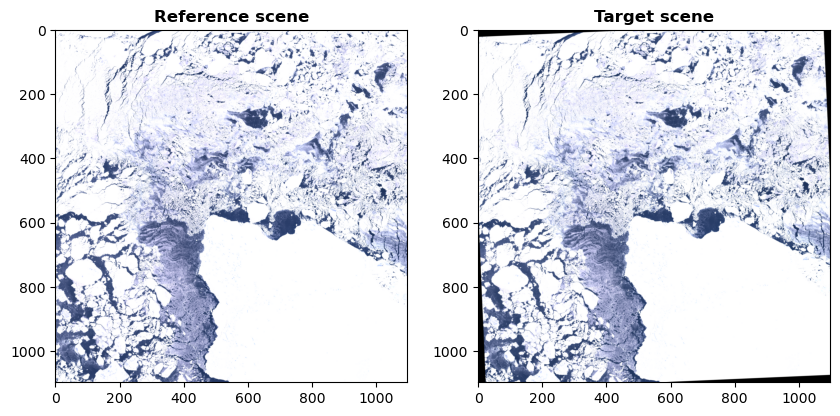

In [4]:
s2_an_l1c_r031_dict = get_scenes_dict(s2_an_df, ["L1C", "R031"], False)
id = list(s2_an_l1c_r031_dict.keys())[0]
tdf = s2_an_df[s2_an_df.ID == id]
tdf = tdf[tdf.Path.apply(lambda x: "L1C" in x)]
tdf = tdf[tdf.Path.apply(lambda x: "N0511_R031" in x)]
s2_an_l1c_secne_files = list(tdf.Path)
ref_id = 4
ref_scene = s2_an_l1c_secne_files[ref_id]

shutil.rmtree(f"../data/inputs/{id}/", ignore_errors=True)
with ZipFile(ref_scene) as f:
        f.extractall(f"../data/inputs/{id}/ref")    
ref_image_dir = os.path.join("../data/inputs/", id, "ref")

ref_tci_files = list(filter(lambda f: "TCI" in f, glob.glob(f"{ref_image_dir}/*/GRANULE/*/IMG_DATA/**", recursive=True)))
ref_tci_files = list(filter(lambda f: "L1C" in f, ref_tci_files))
if len(ref_tci_files) > 1:
    ref_image = [f for f in ref_tci_files if f.endswith("_10m.jp2")][0]
else:
    ref_image = ref_tci_files[0]

print(f"Reference image: {ref_image}")

params = {
    "translation_x": 5.0,
    "translation_y": 10.0,
    "rotation_angle": 2.5,
    "scale": 1.0,
}

tgt_image_dir = os.path.join("../data/inputs/", id, "tgt")
os.makedirs(tgt_image_dir, exist_ok=True)

tgt_image = os.path.join(tgt_image_dir, "tgt.tif")
warp_affine_dataset(ref_image, tgt_image, **params)

_, (axb, axt) = plt.subplots(1,2, figsize=(10, 20))
show(downsample_dataset(ref_image, 0.1)[0], ax=axb, title="Reference scene")
show(downsample_dataset(tgt_image, 0.1)[0], ax=axt, title="Target scene")

In [7]:
ref_image_ds = os.path.join(ref_image_dir, "ref_ds.tif")
downsample_dataset(ref_image, 0.1, ref_image_ds)
tgt_image_ds = os.path.join(tgt_image_dir, "tgt_ds.tif")
downsample_dataset(tgt_image, 0.1, tgt_image_ds)

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], shape=(3, 1098, 1098), dtype=uint8),
 Affine(100.0, 0.0, 399960.0,
        0.0, -100.0, 2800000.0))

In [10]:
ref_img = cv.cvtColor(flip_img(rasterio.open(ref_image).read().copy()), cv.COLOR_BGR2GRAY)
tgt_img = cv.cvtColor(flip_img(rasterio.open(tgt_image).read().copy()), cv.COLOR_BGR2GRAY)
ref_img_ds = cv.cvtColor(flip_img(rasterio.open(ref_image_ds).read().copy()), cv.COLOR_BGR2GRAY)
tgt_img_ds = cv.cvtColor(flip_img(rasterio.open(tgt_image_ds).read().copy()), cv.COLOR_BGR2GRAY)

In [12]:
warp_mode = cv.MOTION_HOMOGRAPHY
warp_matrix = np.eye(3, 3, dtype=np.float32)
number_of_iterations = 5000
termination_eps = 1e-5

criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
(cc, warp_matrix) = cv.findTransformECC(ref_img_ds, tgt_img_ds, warp_matrix, warp_mode, criteria)

tgt_aligned_homography_ds = cv.warpPerspective(tgt_img_ds, warp_matrix, (tgt_img_ds.shape[1], tgt_img_ds.shape[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)
tgt_aligned_homography = cv.warpPerspective(tgt_img, warp_matrix, (tgt_img.shape[1], tgt_img.shape[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)

In [14]:
warp_mode = cv.MOTION_AFFINE
warp_matrix = np.eye(2, 3, dtype=np.float32)
number_of_iterations = 5000
termination_eps = 1e-5

criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
(cc, warp_matrix) = cv.findTransformECC(ref_img_ds, tgt_img_ds, warp_matrix, warp_mode, criteria)

tgt_aligned_affine_ds = cv.warpAffine(tgt_img_ds, warp_matrix, (tgt_img_ds.shape[1], tgt_img_ds.shape[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)
tgt_aligned_affine = cv.warpAffine(tgt_img, warp_matrix, (tgt_img.shape[1], tgt_img.shape[0]), flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP)

Text(0.5, 0, 'Registered (affine), ssim:0.925')

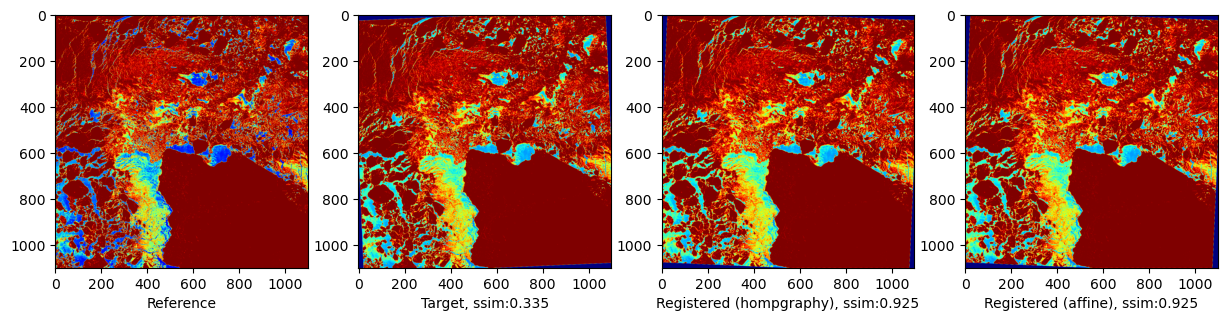

In [16]:
_, axes = plt.subplots(1, 4, figsize=(15, 10))
axes[0].imshow(ref_img_ds, cmap="jet")
axes[0].set_xlabel("Reference")
axes[1].imshow(tgt_img_ds, cmap="jet")
axes[1].set_xlabel(f"Target, ssim:{np.round(ssim(ref_img_ds, tgt_img_ds), 3)}")
axes[2].imshow(tgt_aligned_homography_ds,cmap="jet")
axes[2].set_xlabel(f"Registered (hompgraphy), ssim:{np.round(ssim(ref_img_ds, tgt_aligned_homography_ds), 3)}")
axes[3].imshow(tgt_aligned_affine_ds,cmap="jet")
axes[3].set_xlabel(f"Registered (affine), ssim:{np.round(ssim(ref_img_ds, tgt_aligned_affine_ds), 3)}")

Text(0.5, 0, 'Registered (affine), ssim:0.49')

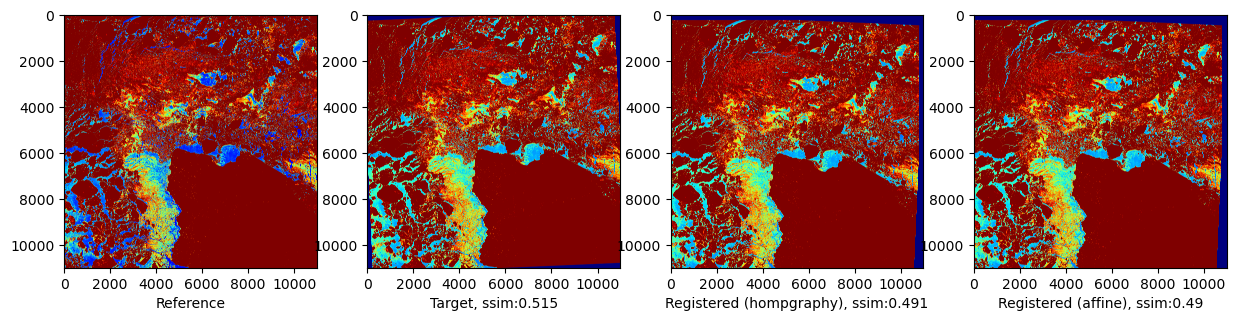

In [17]:
_, axes = plt.subplots(1, 4, figsize=(15, 10))
axes[0].imshow(ref_img, cmap="jet")
axes[0].set_xlabel("Reference")
axes[1].imshow(tgt_img, cmap="jet")
axes[1].set_xlabel(f"Target, ssim:{np.round(ssim(ref_img, tgt_img), 3)}")
axes[2].imshow(tgt_aligned_homography,cmap="jet")
axes[2].set_xlabel(f"Registered (hompgraphy), ssim:{np.round(ssim(ref_img, tgt_aligned_homography), 3)}")
axes[3].imshow(tgt_aligned_affine,cmap="jet")
axes[3].set_xlabel(f"Registered (affine), ssim:{np.round(ssim(ref_img, tgt_aligned_affine), 3)}")